### Problem  
<font size="3">Large number of files were created during the data collection process because ATTOM API returns a maximum of 10,000 records per call.  Hence hundreds of API calls were made to collect non-truncated housing sales data for all counties of California between 1/1/2019 and 1/31/2021. This resulting in 322 files containing over 1 million rows. These files need to be processed and combined into a single dataframe for analysis. Further more, there needs to be a **provision** to process more data if we decide to pull more data from 2018, 2017, 2016 and prior years. We want to avoid running 'for' loops due to speed, efficiency and scalability reasons.

## Solution  
1. We solve this by **PARALLELIZING the Python processing of 322 text files using a DISTRIBUTED CLUSTER with DASK framework.** We use two macbook machines (called A and B) with 2 cores each and 8 GB RAM in each. 3rd or 4th machine can be easily added to the cluster.   

2. We create a basic **PIPELINE** that automatically processes any new incoming JSON containing text file and immediately processes it and appends it to the main dataframe. This is required for scalability should we pull additional data after 2-3 weeks

3. Create HTTP server via Python so that all workers in the cluster have access to it via HTTP. This is a requirement for DASK distributed setup. 

## Implementation
Pandas has 2 bottlenecks - It is not easily scalable over a distributed cluster of machines and uses only 1 core at a time, which makes overall processing slow especially with a dataset with over a million rows. Also, Pandas was not designed for building scalable data pipelines.  Therefore, we use DASK framework which consists of 3 main object classes - dataframe, array and bag. A DASK dataframe is different from a Pandas dataframe.  A DASK scheduler process is initiated on 'A' and 2 'DASK worker' processes are set up ( 1 each on A and B ). 

In [1]:
import pandas as pd
import numpy as np

import dask.array as da
import dask.dataframe as dd
import dask.bag as bag
import json, time, aiohttp

from dask.distributed import LocalCluster, Client

pd.set_option('display.max_columns', 500)

In [62]:
cluster = LocalCluster()
client = Client('tcp://192.168.0.6:8786')
client

/opt/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55699 instead
  warnings.warn(


Client Scheduler: tcp://192.168.0.6:8786 Dashboard: http://192.168.0.6:8787/status,Cluster Workers: 2 Cores: 8 Memory: 17.18 GB


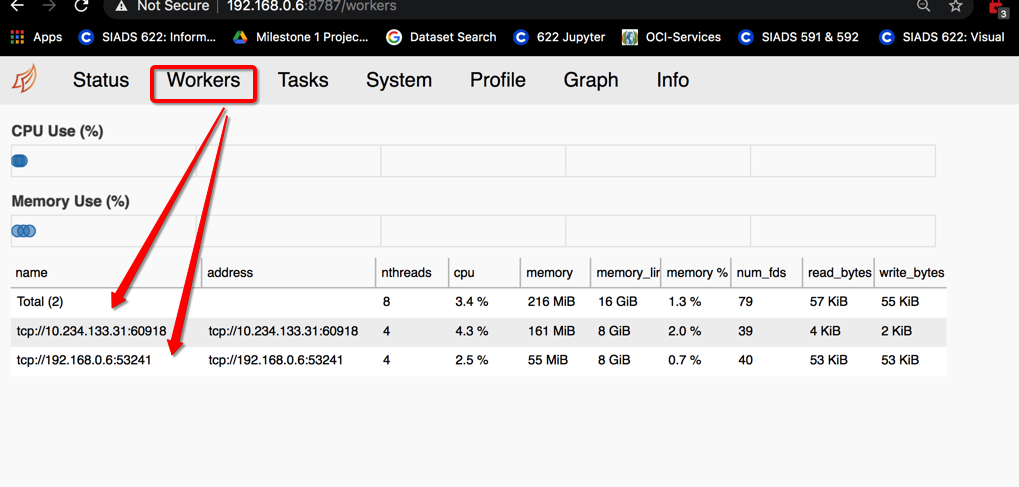

In [63]:
client.scheduler_info()

{'type': 'Scheduler',
 'id': 'Scheduler-b1c052ff-2aa9-486c-acc5-f33e59a73563',
 'address': 'tcp://192.168.0.6:8786',
 'services': {'dashboard': 8787},
 'workers': {'tcp://10.234.133.31:60918': {'type': 'Worker',
   'id': 'tcp://10.234.133.31:60918',
   'host': '10.234.133.31',
   'resources': {},
   'local_directory': '/Users/namita/dask-worker-space/dask-worker-space/worker-7pc7oe0j',
   'name': 'tcp://10.234.133.31:60918',
   'nthreads': 4,
   'memory_limit': 8589934592,
   'last_seen': 1618541682.979007,
   'services': {'dashboard': 60919},
   'metrics': {'cpu': 3.5,
    'memory': 97914880,
    'time': 1618541682.882505,
    'read_bytes': 0.0,
    'write_bytes': 0.0,
    'num_fds': 47,
    'executing': 0,
    'in_memory': 0,
    'ready': 0,
    'in_flight': 0,
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}}},
   'nanny': 'tcp://10.234.133.31:60917'},
  'tcp://192.168.0.6:53241': {'type': 'Worker',
   'id': 'tcp://192.168.0.6:53241',
   'host': '192.168.0.6',
   're

### <font size="5">Conventional Pandas approach

<font size="5">Lets open 1 file. This has 136 rows and 43 columns. We need only 6-8 columns, we'll drop the rest<font>

with open('Housing Full Dataset/CO04012 2019-01-01') as project_file:    
    data = json.load(project_file)  

df_1 = pd.json_normalize(data)
print(df_1.shape)
df_1.columns
cols_of_interest = ['lot.lotSize1','address.postal1', 'summary.propsubtype',
                    'summary.proptype', 'summary.yearbuilt',   'sale.saleTransDate', 'sale.amount.saleamt',
                   'building.size.universalsize','building.rooms.bathstotal', 'building.rooms.beds']
df_1 = df_1[cols_of_interest]
df_1.head(5)
df_1.head()

# DASK approach

### <font size="4"> DASK has 3 main objects - Dataframe, array and bag. DASK dataframe is NOT the same as Pandas dataframe. Dask dataframe is parallelizable, scalable and fast. It has partitions, Pandas dataframe does not have that. Bag is kind of like a python list but it is not iterable. It stores collection of objects. 
    
    https://docs.dask.org/en/latest/bag.html
    https://docs.dask.org/en/latest/bag-api.html

In [64]:
# json.loads function converts JSON string into a python dictionary
def work_read():
    b = bag.read_text('http://192.168.0.6:8000/*').map(json.loads) 
    b = b.flatten()   # without flattening the bag, the results in the bag will be useless due to excessive nesting
    return b

In [65]:
future = client.submit(work_read) 
#y.result()
future

<Future: pending, key: work_read-c58dbbe25c30fa180b687a6f529de674>

In [69]:
future

<Future: finished, type: dask.Bag, key: work_read-c58dbbe25c30fa180b687a6f529de674>

In [67]:
#b.take(1)    # .take() is kind of like Pyspark RDD method. It shows the FIRST n number of records. 
             #  There are 136 records. This is showing just 1 record of 136.

In [70]:
# We define a mapper function which pulls out the useful columns and their values in form of a dictionary 
# using above format

def aditya(record):
    return {
        'transaction_date': record['sale']['saleTransDate'],
        'zipcode': record['address']['postal1'],
        'sale_price':record['sale']['amount']['saleamt'], 
        'lot_size': record['lot']['lotSize1'],
        'size': record['building']['size']['universalsize'],
        'latitude': record ['location']['latitude'],
        'longitude': record['location']['longitude'],
        'type': record['summary']['proptype'],
        'year_built': record['summary']['yearbuilt']
    }

In [71]:
def work_map(future):
    dask_df = future.map(aditya).to_dataframe()
    return dask_df
#print(type(dask_df))
#dask_df.head(20)

In [41]:
big_df = client.submit(work_map,future) 
big_df

<Future: pending, key: work_map-456bf0ead292d38ac67c2b88c642e8a0>

In [77]:
navu_future = client.submit(work_map,future)   # passing aaglu future
navu_future

<Future: finished, type: dask.DataFrame, key: work_map-aef6189f6162f6cbbb4b17450d0be654>

In [78]:
navu_future

<Future: finished, type: dask.DataFrame, key: work_map-aef6189f6162f6cbbb4b17450d0be654>

In [79]:
# CALLING .result() converts future object i.e. remotely stored result into concrete form.
navu_future.result()    

,transaction_date,zipcode,sale_price,lot_size,size,latitude,longitude,type,year_built
npartitions=85,,,,,,,,,
,object,object,int64,float64,int64,object,object,object,int64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


<font size="4">: ABOVE is lazy dataframe. It is perfect and to be expected as it looks. Note Dask dataframe is differnt from pandas df. Dask df has partitions, 1 for each file so total 85 files we have in uploaded on HTTP server. Above dask dataframe called navu_future.result().

MUST NOTE I have uploaded only 2021 folder to HTTP server. This has 85 files.
    
I checked that if i do **navu_future.result( ).head(3)** it will pull 1st few rows of 1st file which is CO04012 2021-01-01 and if i do **future.result( ).tail(3)** it will give last few rows of  LAST file is CO41035 2021-01-01. This is super cool

<font size="5">Check head( ), both are same! Great!

In [111]:
navu_future.result().head(3)

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('head-1-3-to_dataframe-a33a8b2c360c97f0bee25b2a5d7f932f', 0)": ('tcp://10.234.133.31:60918',)}


,transaction_date,zipcode,sale_price,lot_size,size,latitude,longitude,type,year_built
0,2021-1-1,85344,265000,0.1148,1624,34.191529,-114.220966,SFR,1995
1,2021-1-2,85346,500000,1.9968,5168,33.664570,-114.228435,STORE BUILDING,2006
2,2021-1-4,85344,459250,0.0579,2391,34.205912,-114.216127,CONDOMINIUM,0


In [113]:
df_firstfile.head(3)   # same as future nu....this is JUST TO CHECK

,lot.lotSize1,address.postal1,summary.propsubtype,summary.proptype,summary.yearbuilt,sale.saleTransDate,sale.amount.saleamt,building.size.universalsize,building.rooms.bathstotal,building.rooms.beds
0,0.1148,85344,HOUSE,SFR,1995,2021-1-1,265000,1624,0.0,0
1,1.9968,85346,COMMERCIAL,STORE BUILDING,2006,2021-1-2,500000,5168,0.0,0
2,0.0579,85344,RESIDENTIAL,CONDOMINIUM,0,2021-1-4,459250,2391,0.0,0


<font size="5"> Check tail( ) ...both are same BELOW...great!

In [118]:
navu_future.result().tail(3)

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('tail-3-to_dataframe-a33a8b2c360c97f0bee25b2a5d7f932f', 0)": ('tcp://10.234.133.31:60918',)}


,transaction_date,zipcode,sale_price,lot_size,size,latitude,longitude,type,year_built
100,2021-2-26,97603,275000,0.36,0,42.198855,-121.701953,COMMON AREA,0
101,2021-2-26,97633,650000,42.66,1428,42.023983,-121.560540,FARMS,0
102,2021-2-26,97603,3200000,3.30,51906,42.189070,-121.733425,MULTI FAMILY DWELLING,0


In [119]:
df_lastfile.tail(3)

,lot.lotSize1,address.postal1,summary.propsubtype,summary.proptype,summary.yearbuilt,sale.saleTransDate,sale.amount.saleamt,building.size.universalsize,building.rooms.bathstotal,building.rooms.beds
100,0.36,97603,COMMERCIAL,COMMON AREA,0,2021-2-26,275000,0,0.0,0
101,42.66,97633,HOUSE,FARMS,0,2021-2-26,650000,1428,1.0,0
102,3.30,97603,COMMERCIAL,MULTI FAMILY DWELLING,0,2021-2-26,3200000,51906,0.0,0


### END OF WORKBOOK...1 million rows!! 1,017,244 rows 2019 to today!

<font size="5"> Goal achieved: 
    We combined approx 330 files into 1 single dataframe...please note its  DASK df and NOT Pandas df! You can't see whole dataframe at once. This is specifically to facilitate parallel and fast processing. More data can be added and this code won't change a bit!



#### THIS CODE CELL IS JUST TO CHECK...###UNCOMMENT IF NEEDED

with open('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/2021 California housing sales transactions upto 31 march/CO41035 2021-01-01') as project_file:    
    data = json.load(project_file)  

df_lastfile = pd.json_normalize(data)
#print(df_1astfile.shape)
cols_of_interest = ['lot.lotSize1','address.postal1', 'summary.propsubtype',
                    'summary.proptype', 'summary.yearbuilt',   'sale.saleTransDate', 'sale.amount.saleamt',
                   'building.size.universalsize','building.rooms.bathstotal', 'building.rooms.beds']
df_lastfile = df_lastfile[cols_of_interest]
df_lastfile.head(3)


#### THIS CODE CELL IS JUST TO CHECK...### UNCOMMENT IF NEEDED

with open('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/2021 California housing sales transactions upto 31 march/CO04012 2021-01-01') as project_file:    
    data = json.load(project_file)  

df_firstfile = pd.json_normalize(data)
print(df_firstfile.shape)
df_firstfile.columns
cols_of_interest = ['lot.lotSize1','address.postal1', 'summary.propsubtype',
                    'summary.proptype', 'summary.yearbuilt',   'sale.saleTransDate', 'sale.amount.saleamt',
                   'building.size.universalsize','building.rooms.bathstotal', 'building.rooms.beds']
df_firstfile = df_firstfile[cols_of_interest]
df_firstfile.head(3)
